In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score

import scikitplot as skplt
from scikitplot.helpers import binary_ks_curve

import optuna
from optuna.trial import TrialState

In [3]:
keras.utils.set_random_seed(42)

##### Carregando o dataset

In [4]:
df_train = pd.read_csv('../data/treated_data/train.csv')
df_val = pd.read_csv('../data/treated_data/validation.csv')
df_test = pd.read_csv('../data/treated_data/test.csv')

In [5]:
X_train = df_train.drop(['satisfaction'], axis=1).values
y_train = df_train['satisfaction'].values

X_val = df_val.drop(['satisfaction'], axis=1).values
y_val = df_val['satisfaction'].values

X_test = df_test.drop(['satisfaction'], axis=1).values
y_test = df_test['satisfaction'].values

##### Declarando as funções de metricas

In [6]:
def plot_roc_curve(y_pred: np.array, y_test: np.array) -> None:
    
    # Obter as probabilidades da classe positiva
    y_pred_positive = y_pred[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_positive)
    roc_auc = roc_auc_score(y_test, y_pred_positive)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})' )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()



In [7]:
def plot_confusion_matrix(y_pred: np.array, y_test: np.array) -> None:
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unsatisfied', 'Satisfied'], yticklabels=['Unsatisfied', 'Satisfied'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [8]:
def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

In [9]:
def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

##### Criando o modelo MLP

In [10]:
model = Sequential([
    # Input layer
    Input(shape=(X_train.shape[1],)),

    # Hidden layers
    Dense(50, activation='relu'),
    Dropout(0.2),

    # Output layer
    Dense(2, activation='softmax')
])

In [11]:
model.compile(
    optimizer=Adam(), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [12]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │         1,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,852 (7.23 KB)

 Trainable params: 1,852 (7.23 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
    X_train,
    y_train, 
    epochs=15, 
    batch_size=32, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping]
)

Epoch 1/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8313 - loss: 0.3913 - val_accuracy: 0.9121 - val_loss: 0.2220
Epoch 2/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9085 - loss: 0.2258 - val_accuracy: 0.9289 - val_loss: 0.1818
Epoch 3/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9211 - loss: 0.1904 - val_accuracy: 0.9349 - val_loss: 0.1618
Epoch 4/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9295 - loss: 0.1713 - val_accuracy: 0.9391 - val_loss: 0.1525
Epoch 5/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9334 - loss: 0.1605 - val_accuracy: 0.9404 - val_loss: 0.1467
Epoch 6/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9343 - loss: 0.1548 - val_accuracy: 0.9423 - val_loss: 0.1412
Epoch 7/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9361 - loss: 0.1510 - val_accuracy: 0.9443 - val_loss: 0.1371
Epoch 8/15
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9392 - loss: 0.1478 - 

##### Avaliando o modelo

In [15]:
mlp_pred_scores = model.predict(X_test)
mlp_pred_class = np.argmax(mlp_pred_scores, axis=1)

1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step


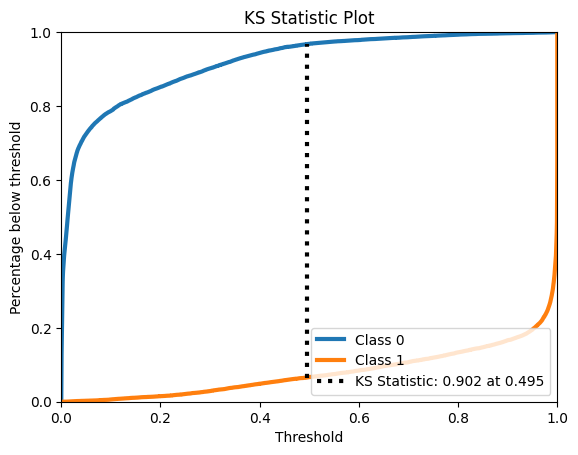



Multi Layer Perceptron - Test

Accuracy:         0.9532
Recall:           0.9334
Precision:        0.9577
F1:               0.9454
AUROC:            0.9912
AUPR:             0.9898


In [16]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, mlp_pred_class, mlp_pred_scores)
print('\n\nMulti Layer Perceptron - Test')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

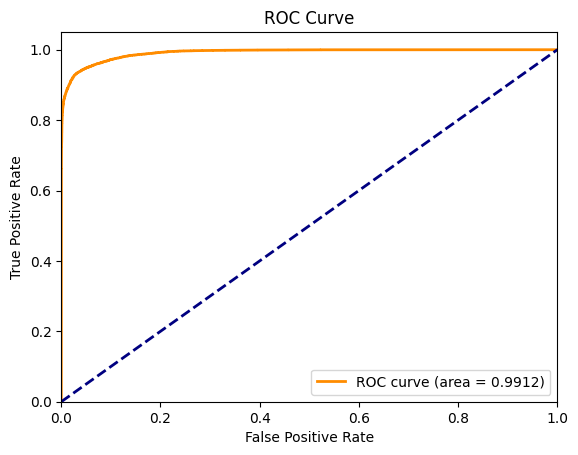

In [17]:
plot_roc_curve(mlp_pred_scores, y_test)

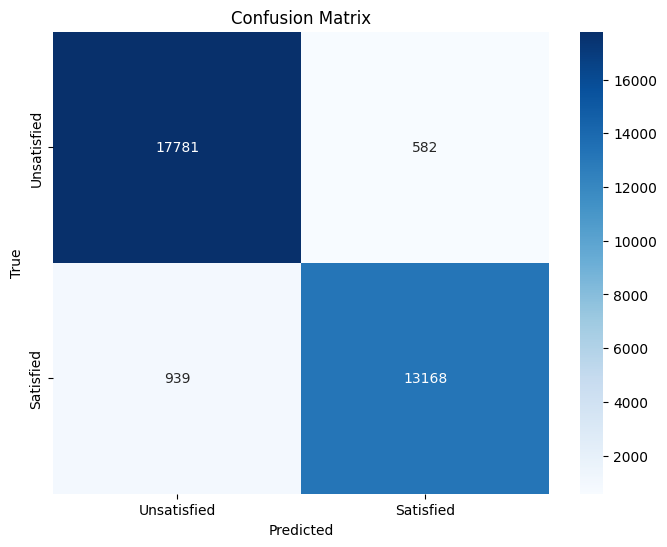

In [18]:
plot_confusion_matrix(y_pred=mlp_pred_class, y_test=y_test)

#### Usando o Optune para encontrar os melhores Hiperparâmetros

Primeiro iremos criar uma função objetivo, com foco em maximizar o AOC e o K-S

In [19]:
import numpy as np
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Assumindo que essas variáveis globais já foram definidas
# x_train, y_train, X_val, y_val, X_test, y_test, early_stopping

def objective(trial):

    global x_train
    global y_train

    global X_val
    global y_val

    global X_test
    global y_test

    global early_stopping
    
    params = {
        'n_hidden_layers': trial.suggest_int('n_hidden_layers', 1, 5),  # Número de camadas ocultas
        'units_per_layer': trial.suggest_int('units_per_layer', 10, 200, step=3),  # Número de unidades por camada
        'activation_function': trial.suggest_categorical('activation_function', ['relu', 'sigmoid', 'tanh']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'SGD', 'rmsprop']),
        'batch_size': trial.suggest_int('batch_size', 32, 160, step=32),
        'dropout': trial.suggest_float('dropout', 0.0, 0.8, step=0.1)  # Usando float para dropout
    }

    trial.set_user_attr("n_hidden_layers", params["n_hidden_layers"])
    trial.set_user_attr("units_per_layer", params["units_per_layer"])
    trial.set_user_attr("activation_function", params["activation_function"])
    trial.set_user_attr("optimizer", params["optimizer"])
    trial.set_user_attr("batch_size", params["batch_size"])
    trial.set_user_attr("dropout", params["dropout"])

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    # Adiciona as camadas ocultas
    for _ in range(params['n_hidden_layers']):
        model.add(Dense(params['units_per_layer'], activation=params['activation_function']))
        model.add(Dropout(params['dropout']))

    # Adiciona a camada de saída
    model.add(Dense(2, activation='softmax'))
    
    model.compile(
        optimizer=params['optimizer'], 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )

    model.summary()

    history = model.fit(
        X_train,
        y_train, 
        epochs=25, 
        batch_size=params['batch_size'], 
        validation_data=(X_val, y_val), 
        callbacks=[early_stopping]
    )

    y_pred_test_scores = model.predict(X_test)
    y_pred_test_class = np.argmax(y_pred_test_scores, axis=1)
    
    thresholds, pct1, pct2, ks_statistic, \
        max_distance_at, classes = binary_ks_curve(y_test, y_pred_test_scores[:, 1].ravel())

    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_test_class, y_pred_test_scores)
    print(f'\n\nMLP\nn_hidden_layers: {params["n_hidden_layers"]}\nunits_per_layer: {params["units_per_layer"]}\nactivation_function: {params["activation_function"]}\noptimizer: {params["optimizer"]}\nbatch_size: {params["batch_size"]}')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    

    trial.set_user_attr("accuracy", accuracy)
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("f1", f1)
    trial.set_user_attr("auroc", auroc)
    trial.set_user_attr("ks_statistic", ks_statistic)
    trial.set_user_attr("max_distance_at", max_distance_at)
    
    return auroc, ks_statistic

[I 2024-07-30 17:13:05,871] A new study created in memory with name: no-name-9a3a6039-a1b9-4106-ae7c-6cb3f21fb603


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 160)            │         5,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 160)            │        25,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,682 (123.76 KB)

 Trainable params: 31,682 (123.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6078 - loss: 0.7051 - val_accuracy: 0.8289 - val_loss: 0.4018
Epoch 2/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8067 - loss: 0.4449 - val_accuracy: 0.8576 - val_loss: 0.3506
Epoch 3/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8368 - loss: 0.3920 - val_accuracy: 0.8652 - val_loss: 0.3344
Epoch 4/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8465 - loss: 0.3725 - val_accuracy: 0.8673 - val_loss: 0.3273
Epoch 5/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8510 - loss: 0.3646 - val_accuracy: 0.8687 - val_loss: 0.3252
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step


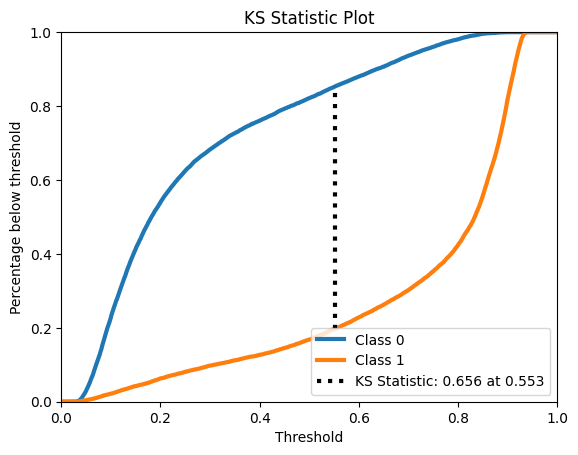

[I 2024-07-30 17:13:12,755] Trial 0 finished with values: [0.9042968005157028, 0.6563130526652513] and parameters: {'n_hidden_layers': 2, 'units_per_layer': 160, 'activation_function': 'sigmoid', 'optimizer': 'adam', 'batch_size': 160, 'dropout': 0.7000000000000001}. 




MLP
n_hidden_layers: 2
units_per_layer: 160
activation_function: sigmoid
optimizer: adam
batch_size: 160

Accuracy:         0.8261
Recall:           0.8321
Precision:        0.7818
F1:               0.8062
AUROC:            0.9043
AUPR:             0.9043


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 121)            │         4,235 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 121)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │           244 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,479 (17.50 KB)

 Trainable params: 4,479 (17.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8273 - loss: 0.3918 - val_accuracy: 0.9120 - val_loss: 0.2243
Epoch 2/25
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9033 - loss: 0.2392 - val_accuracy: 0.9276 - val_loss: 0.1859
Epoch 3/25
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9161 - loss: 0.2084 - val_accuracy: 0.9320 - val_loss: 0.1677
Epoch 4/25
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9207 - loss: 0.1914 - val_accuracy: 0.9360 - val_loss: 0.1586
Epoch 5/25
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9264 - loss: 0.1810 - val_accuracy: 0.9381 - val_loss: 0.1549
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/step


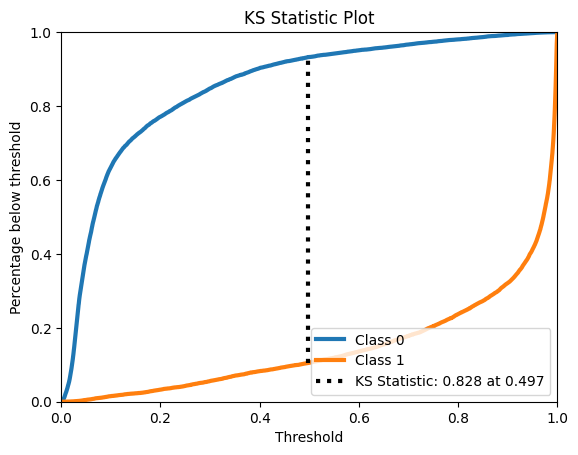

[I 2024-07-30 17:13:28,197] Trial 1 finished with values: [0.9704130362276836, 0.8277134867666656] and parameters: {'n_hidden_layers': 1, 'units_per_layer': 121, 'activation_function': 'relu', 'optimizer': 'rmsprop', 'batch_size': 32, 'dropout': 0.5}. 




MLP
n_hidden_layers: 1
units_per_layer: 121
activation_function: relu
optimizer: rmsprop
batch_size: 32

Accuracy:         0.9161
Recall:           0.8946
Precision:        0.9108
F1:               0.9026
AUROC:            0.9704
AUPR:             0.9674


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 175)            │         6,125 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 175)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 175)            │        30,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 175)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 175)            │        30,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 175)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │           352 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,077 (265.93 KB)

 Trainable params: 68,077 (265.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7567 - loss: 0.4989 - val_accuracy: 0.8911 - val_loss: 0.2776
Epoch 2/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8819 - loss: 0.3037 - val_accuracy: 0.9189 - val_loss: 0.2054
Epoch 3/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9063 - loss: 0.2413 - val_accuracy: 0.9312 - val_loss: 0.1756
Epoch 4/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9153 - loss: 0.2135 - val_accuracy: 0.9362 - val_loss: 0.1595
Epoch 5/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9206 - loss: 0.1952 - val_accuracy: 0.9380 - val_loss: 0.1544
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step


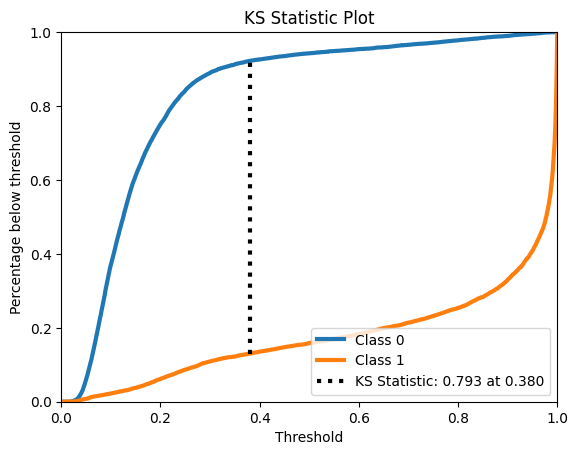

[I 2024-07-30 17:13:36,412] Trial 2 finished with values: [0.9481836703810643, 0.7926642077831785] and parameters: {'n_hidden_layers': 3, 'units_per_layer': 175, 'activation_function': 'relu', 'optimizer': 'adam', 'batch_size': 160, 'dropout': 0.6000000000000001}. 




MLP
n_hidden_layers: 3
units_per_layer: 175
activation_function: relu
optimizer: adam
batch_size: 160

Accuracy:         0.8988
Recall:           0.8415
Precision:        0.9187
F1:               0.8784
AUROC:            0.9482
AUPR:             0.9513


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 136)            │         4,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 136)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 136)            │        18,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 136)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 136)            │        18,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 136)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 136)            │        18,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 136)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 136)            │        18,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 136)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 2)              │           274 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,562 (310.79 KB)

 Trainable params: 79,562 (310.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
766/766 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6871 - loss: 0.5422 - val_accuracy: 0.8620 - val_loss: 0.3345
Epoch 2/25
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8567 - loss: 0.3520 - val_accuracy: 0.8694 - val_loss: 0.3213
Epoch 3/25
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8616 - loss: 0.3409 - val_accuracy: 0.8685 - val_loss: 0.3200
Epoch 4/25
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8656 - loss: 0.3353 - val_accuracy: 0.8719 - val_loss: 0.3167
Epoch 5/25
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8653 - loss: 0.3326 - val_accuracy: 0.8734 - val_loss: 0.3133
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step


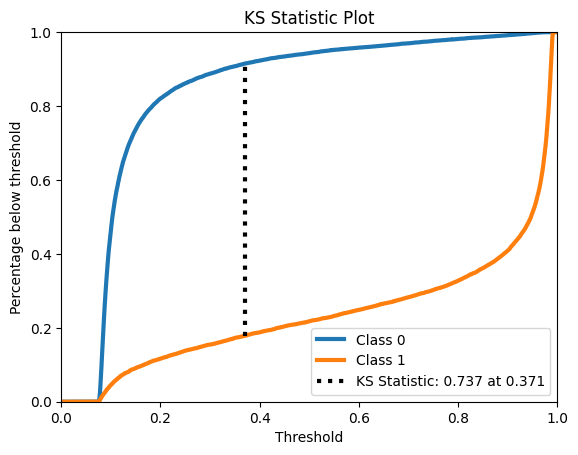

[I 2024-07-30 17:13:48,249] Trial 3 finished with values: [0.9256365878632737, 0.7367550141250323] and parameters: {'n_hidden_layers': 5, 'units_per_layer': 136, 'activation_function': 'sigmoid', 'optimizer': 'adam', 'batch_size': 96, 'dropout': 0.2}. 




MLP
n_hidden_layers: 5
units_per_layer: 136
activation_function: sigmoid
optimizer: adam
batch_size: 96

Accuracy:         0.8731
Recall:           0.7822
Precision:        0.9131
F1:               0.8426
AUROC:            0.9256
AUPR:             0.9311


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 43)             │         1,505 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 43)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 43)             │         1,892 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 43)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 43)             │         1,892 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 43)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 43)             │         1,892 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 43)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 43)             │         1,892 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 43)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2)              │            88 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,161 (35.79 KB)

 Trainable params: 9,161 (35.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4988 - loss: 0.7350 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/25
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4987 - loss: 0.7010 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/25
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5041 - loss: 0.6952 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/25
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4972 - loss: 0.6948 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/25
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5020 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.6932
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step


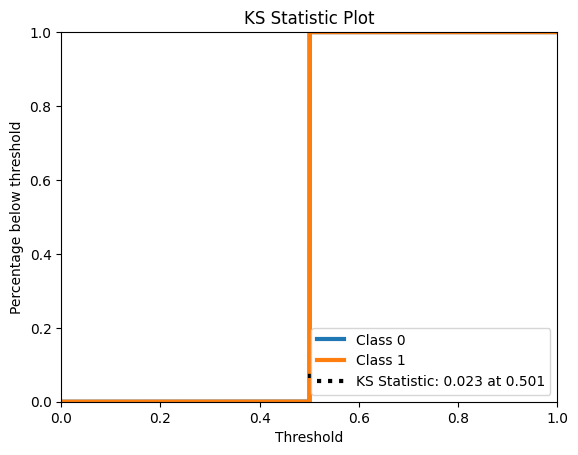

[I 2024-07-30 17:13:57,869] Trial 4 finished with values: [0.3755951515347759, 0.0228763608045697] and parameters: {'n_hidden_layers': 5, 'units_per_layer': 43, 'activation_function': 'sigmoid', 'optimizer': 'SGD', 'batch_size': 64, 'dropout': 0.4}. 




MLP
n_hidden_layers: 5
units_per_layer: 43
activation_function: sigmoid
optimizer: SGD
batch_size: 64

Accuracy:         0.4345
Recall:           1.0000
Precision:        0.4345
F1:               0.6057
AUROC:            0.3756
AUPR:             0.3429


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 145)            │         5,075 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 145)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 145)            │        21,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 145)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 145)            │        21,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 145)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 145)            │        21,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 145)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2)              │           292 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,877 (269.05 KB)

 Trainable params: 68,877 (269.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8808 - loss: 0.2866 - val_accuracy: 0.9329 - val_loss: 0.1597
Epoch 2/25
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9325 - loss: 0.1570 - val_accuracy: 0.9397 - val_loss: 0.1406
Epoch 3/25
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9380 - loss: 0.1448 - val_accuracy: 0.9421 - val_loss: 0.1341
Epoch 4/25
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9425 - loss: 0.1337 - val_accuracy: 0.9470 - val_loss: 0.1263
Epoch 5/25
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9449 - loss: 0.1299 - val_accuracy: 0.9449 - val_loss: 0.1293
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step


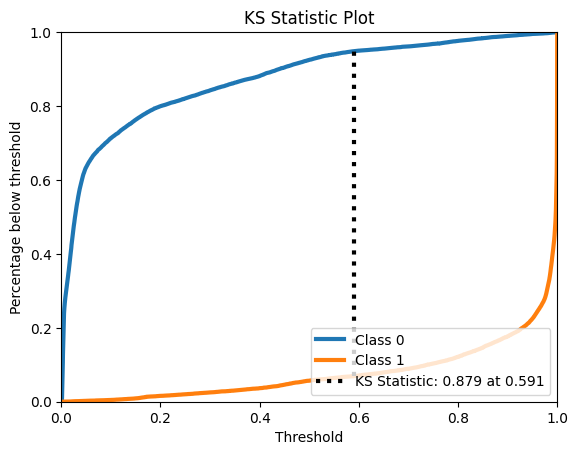

[I 2024-07-30 17:14:18,435] Trial 5 finished with values: [0.9856405660627223, 0.8792814230844065] and parameters: {'n_hidden_layers': 4, 'units_per_layer': 145, 'activation_function': 'tanh', 'optimizer': 'adam', 'batch_size': 32, 'dropout': 0.0}. 




MLP
n_hidden_layers: 4
units_per_layer: 145
activation_function: tanh
optimizer: adam
batch_size: 32

Accuracy:         0.9327
Recall:           0.9430
Precision:        0.9060
F1:               0.9241
AUROC:            0.9856
AUPR:             0.9832


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 100)            │         3,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,002 (132.82 KB)

 Trainable params: 34,002 (132.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6206 - loss: 0.7255 - val_accuracy: 0.8126 - val_loss: 0.4425
Epoch 2/25
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7951 - loss: 0.4753 - val_accuracy: 0.8525 - val_loss: 0.3722
Epoch 3/25
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8303 - loss: 0.4168 - val_accuracy: 0.8655 - val_loss: 0.3548
Epoch 4/25
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8442 - loss: 0.3911 - val_accuracy: 0.8706 - val_loss: 0.3449
Epoch 5/25
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8523 - loss: 0.3742 - val_accuracy: 0.8715 - val_loss: 0.3421
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step


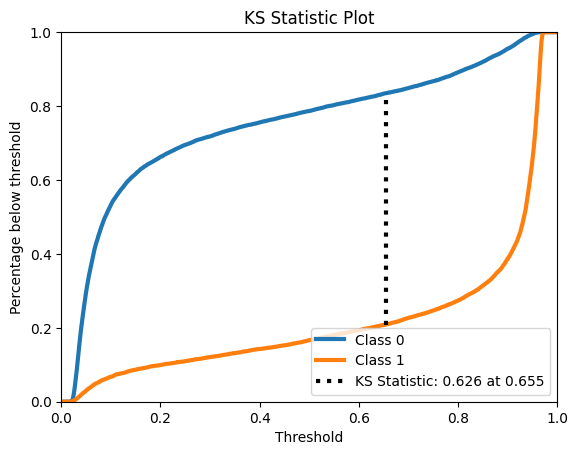

[I 2024-07-30 17:14:29,752] Trial 6 finished with values: [0.8920306829759796, 0.6261453580126847] and parameters: {'n_hidden_layers': 4, 'units_per_layer': 100, 'activation_function': 'tanh', 'optimizer': 'SGD', 'batch_size': 64, 'dropout': 0.6000000000000001}. 




MLP
n_hidden_layers: 4
units_per_layer: 100
activation_function: tanh
optimizer: SGD
batch_size: 64

Accuracy:         0.8071
Recall:           0.8338
Precision:        0.7500
F1:               0.7897
AUROC:            0.8920
AUPR:             0.8872


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 16)             │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,138 (4.45 KB)

 Trainable params: 1,138 (4.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5030 - loss: 0.8210 - val_accuracy: 0.6463 - val_loss: 0.6922
Epoch 2/25
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5238 - loss: 0.6906 - val_accuracy: 0.7914 - val_loss: 0.6175
Epoch 3/25
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6306 - loss: 0.6515 - val_accuracy: 0.8037 - val_loss: 0.5227
Epoch 4/25
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6829 - loss: 0.6149 - val_accuracy: 0.8188 - val_loss: 0.4864
Epoch 5/25
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7097 - loss: 0.5921 - val_accuracy: 0.8360 - val_loss: 0.4530
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 608us/step


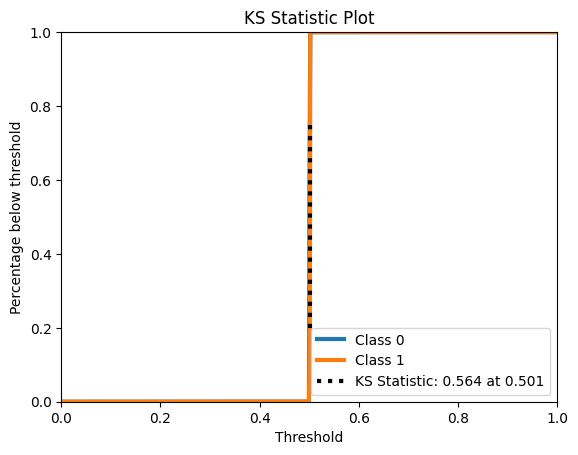

[I 2024-07-30 17:14:46,919] Trial 7 finished with values: [0.8501067959365696, 0.564229026826851] and parameters: {'n_hidden_layers': 3, 'units_per_layer': 16, 'activation_function': 'sigmoid', 'optimizer': 'rmsprop', 'batch_size': 32, 'dropout': 0.8}. 




MLP
n_hidden_layers: 3
units_per_layer: 16
activation_function: sigmoid
optimizer: rmsprop
batch_size: 32

Accuracy:         0.6042
Recall:           0.9568
Precision:        0.5244
F1:               0.6775
AUROC:            0.8501
AUPR:             0.8115


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_37 (Dense)                │ (None, 136)            │         4,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 136)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 136)            │        18,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 136)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 136)            │        18,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 136)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 136)            │        18,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 136)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 2)              │           274 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,930 (238.01 KB)

 Trainable params: 60,930 (238.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8377 - loss: 0.3685 - val_accuracy: 0.9259 - val_loss: 0.1876
Epoch 2/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9151 - loss: 0.2039 - val_accuracy: 0.9404 - val_loss: 0.1459
Epoch 3/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9331 - loss: 0.1605 - val_accuracy: 0.9459 - val_loss: 0.1299
Epoch 4/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9403 - loss: 0.1436 - val_accuracy: 0.9482 - val_loss: 0.1237
Epoch 5/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9427 - loss: 0.1329 - val_accuracy: 0.9502 - val_loss: 0.1178
Epoch 6/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9457 - loss: 0.1280 - val_accuracy: 0.9503 - val_loss: 0.1165
Epoch 7/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9490 - loss: 0.1222 - val_accuracy: 0.9527 - val_loss: 0.1138
Epoch 8/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9503 - loss: 0.1193 - val_accuracy: 0.

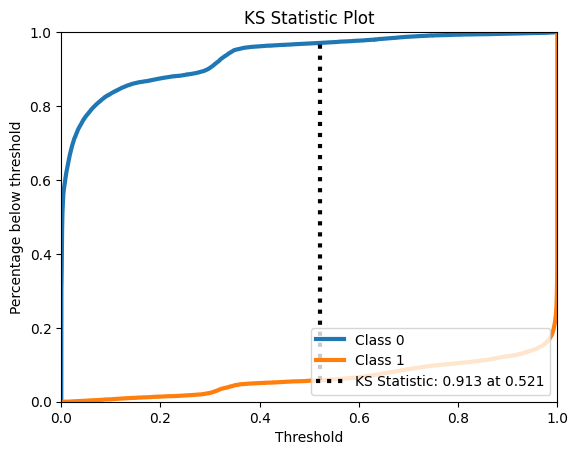

[I 2024-07-30 17:15:11,204] Trial 8 finished with values: [0.9932949037583514, 0.912896359156914] and parameters: {'n_hidden_layers': 4, 'units_per_layer': 136, 'activation_function': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128, 'dropout': 0.1}. 




MLP
n_hidden_layers: 4
units_per_layer: 136
activation_function: relu
optimizer: rmsprop
batch_size: 128

Accuracy:         0.9578
Recall:           0.9431
Precision:        0.9591
F1:               0.9510
AUROC:            0.9933
AUPR:             0.9921


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 118)            │         4,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 118)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 118)            │        14,042 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 118)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 2)              │           238 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,410 (71.91 KB)

 Trainable params: 18,410 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6672 - loss: 0.5982 - val_accuracy: 0.8529 - val_loss: 0.3567
Epoch 2/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8408 - loss: 0.3852 - val_accuracy: 0.8665 - val_loss: 0.3309
Epoch 3/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8529 - loss: 0.3574 - val_accuracy: 0.8698 - val_loss: 0.3240
Epoch 4/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8596 - loss: 0.3473 - val_accuracy: 0.8703 - val_loss: 0.3214
Epoch 5/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8618 - loss: 0.3427 - val_accuracy: 0.8703 - val_loss: 0.3196
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 1s 543us/step


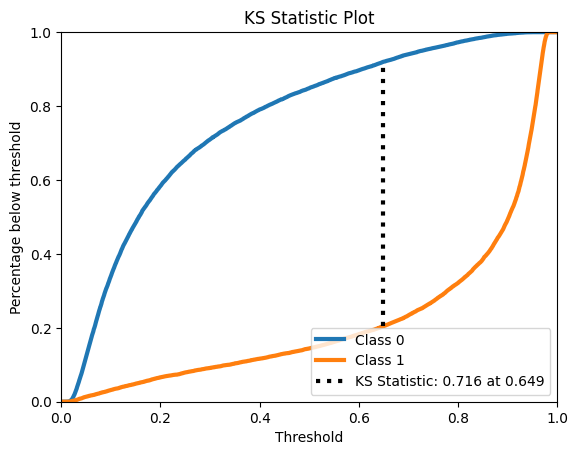

[I 2024-07-30 17:15:16,539] Trial 9 finished with values: [0.9203685579782848, 0.7160228446869963] and parameters: {'n_hidden_layers': 2, 'units_per_layer': 118, 'activation_function': 'sigmoid', 'optimizer': 'adam', 'batch_size': 160, 'dropout': 0.4}. 




MLP
n_hidden_layers: 2
units_per_layer: 118
activation_function: sigmoid
optimizer: adam
batch_size: 160

Accuracy:         0.8516
Recall:           0.8557
Precision:        0.8127
F1:               0.8336
AUROC:            0.9204
AUPR:             0.9244


In [20]:
study = optuna.create_study(directions=['maximize', 'maximize'])
study.optimize(objective, n_trials=10)

#### Salvando os resultados no csv e visualizando os resultados

In [21]:
df = study.trials_dataframe()
df = df[df["state"] == "COMPLETE"].drop(["datetime_start", "datetime_complete", "duration", "state"], axis=1)
df = df.sort_values(['values_0', 'values_1']) 

csv_file = "../results/optuna_results_mlp.csv"
df_existing = pd.read_csv(csv_file) if os.path.isfile(csv_file) else None

df_existing = pd.concat([df_existing, df], ignore_index=True) if df_existing is not None else df
df_existing.to_csv(csv_file, index=False)

In [22]:
df_existing

,number,values_0,values_1,params_activation_function,params_batch_size,params_n_hidden_layers,params_optimizer,user_attrs_accuracy,user_attrs_activation_function,user_attrs_auroc,...,user_attrs_max_distance_at,user_attrs_n_hidden_layers,user_attrs_optimizer,user_attrs_precision,user_attrs_recall,system_attrs_nsga2:generation,params_dropout,user_attrs_dropout,params_units_per_layer,user_attrs_units_per_layer
0,10,0.431994,0.045550,softmax,64,220,SGD,0.950724,softmax,0.431994,...,0.500170,220,SGD,0.948055,0.937974,0,NaN,NaN,NaN,NaN
1,3,0.463689,0.050850,softmax,64,280,SGD,0.950724,softmax,0.463689,...,0.499692,280,SGD,0.948055,0.937974,0,NaN,NaN,NaN,NaN
2,37,0.675989,0.266699,softmax,64,180,SGD,0.950724,softmax,0.675989,...,0.500848,180,SGD,0.948055,0.937974,0,NaN,NaN,NaN,NaN
3,39,0.820313,0.506949,softmax,64,40,SGD,0.950724,softmax,0.820313,...,0.505659,40,SGD,0.948055,0.937974,0,NaN,NaN,NaN,NaN
4,46,0.837507,0.532143,sigmoid,128,320,SGD,0.950724,sigmoid,0.837507,...,0.496873,320,SGD,0.948055,0.937974,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,3,0.925637,0.736755,sigmoid,96,5,adam,0.873052,sigmoid,0.925637,...,0.370991,5,adam,0.913115,0.782236,0,0.2,0.2,136.0,136.0
206,2,0.948184,0.792664,relu,160,3,adam,0.898768,relu,0.948184,...,0.380381,3,adam,0.918666,0.841497,0,0.6,0.6,175.0,175.0
207,1,0.970413,0.827713,relu,32,1,rmsprop,0.916138,relu,0.970413,...,0.497092,1,rmsprop,0.910797,0.894591,0,0.5,0.5,121.0,121.0
208,5,0.985641,0.879281,tanh,32,4,adam,0.932707,tanh,0.985641,...,0.591039,4,adam,0.905952,0.943007,0,0.0,0.0,145.0,145.0


In [23]:
best_trial = study.best_trials[0]
print("\n-- Best Trial --")
print(f"  Accuracy:  {best_trial.user_attrs['accuracy']}")
print(f"  Precision: {best_trial.user_attrs['precision']}")
print(f"  Recall:    {best_trial.user_attrs['recall']}")
print(f"  F1 Score:  {best_trial.user_attrs['f1']}")
print(f"  auroc:  {best_trial.user_attrs['auroc']}")
print(f"  ks_statistic:  {best_trial.user_attrs['ks_statistic']}")
print(f"  max_distance_at:  {best_trial.user_attrs['max_distance_at']}")

print("  Parameters: ")
for key, val in best_trial.params.items():
    print(f"    {key}: {(16 - len(key)) * ' '}{val}")


print(f"\n-- Overall Results (Ordered by auroc) --")
print(df)

most_important_parameters = optuna.importance.get_param_importances(study, target=lambda t: t.values[0])

print("\n-- Most Important Hyperparameters --")
for key, val in most_important_parameters.items():
    print(f"  {key}: {(15 - len(key)) * ' '}{(100 * val):.2f}%")


-- Best Trial --
  Accuracy:  0.9578072066522945
  Precision: 0.9590571613926332
  Recall:    0.9431487913801658
  F1 Score:  0.9510364546104361
  auroc:  0.9932949037583514
  ks_statistic:  0.912896359156914
  max_distance_at:  0.521221399307251
  Parameters: 
    n_hidden_layers:  4
    units_per_layer:  136
    activation_function: relu
    optimizer:        rmsprop
    batch_size:       128
    dropout:          0.1

-- Overall Results (Ordered by auroc) --
   number  values_0  values_1 params_activation_function  params_batch_size  \
4       4  0.375595  0.022876                    sigmoid                 64   
7       7  0.850107  0.564229                    sigmoid                 32   
6       6  0.892031  0.626145                       tanh                 64   
0       0  0.904297  0.656313                    sigmoid                160   
9       9  0.920369  0.716023                    sigmoid                160   
3       3  0.925637  0.736755                    sigmoid   